# Intro to Deep Learning

Now that we have a better hold on traditional ML models from last week, we'll start to look at deep learning.

![neural network image](https://miro.medium.com/max/1400/0*_SH7tsNDTkGXWtZb.png
)

## Why Deep Learning
- Deep learning is used commonly today to deal with non-tabular datasets such as images, text, and speech.  
    - Common use cases include object recognition (draw bounding boxes around each object in an image), text translation (google translate), and text to speech algorithms like alexa.
- We need a different set of algorithms to handle these use cases because 
usually we need a way to learn features of the input data, and we want to learn features with multiple layers of abstraction
    - this contrasts with traditional ML since we usually already have features in our input data (for example tabular data), whereas if we want a model to tell us if an image is a dog or not, then we have no way to easily feed features to the model (eg a dog has 4 legs, a tail, and is fluffy)


## Similarities to Traditional ML
- We still have the same types of learning: supervised and unsupervised
    - reinforcement learning really only works with deep learning


## What we're going to work on today
- Today we're going to introduce everyone to Keras, a simple deep learning library in python
- we'll also start working with non-tabular data domains by talking about how we can build an algorithm to recognize handwritten digits
- finally we'll discuss the concept of a Neural Network and a Convolutional Nerual Network




In [1]:
%matplotlib inline 
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices()) # this will let us run on the GPU if we have it

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16879338153366029070
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2110080074044095204
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets - similar to sklearn
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# the images are just 2d numpy arrays


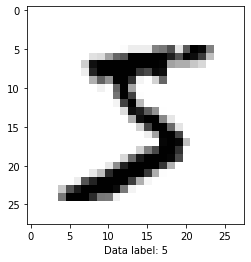

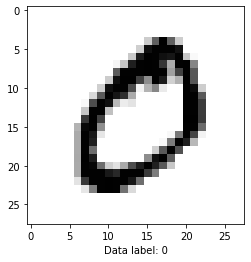

In [3]:
from matplotlib import pyplot as plt

for i in range(2):
    img = x_train[i]
    cls = y_train[i]
    plt.imshow(img, interpolation='nearest', cmap=plt.cm.binary)
    plt.xlabel(f"Data label: {cls}")
    plt.show()


# data preprocessing
- currently our data is a grayscale image, so each of our values are in the range [0, 255] (RGB colors are 8 bit)
    - just as with normal data cleaning, we like to have our values in some predefined range because big numbers can lead to numerical errors when using models, so we'd like to get everything in the range [0, 1] instead

In [4]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Building the Model

- Now we have to actually build our model.  In deep learning, models are comprised of individual units called layers, which is just a function that takes in inputs and gives an output.  

## Convolutions
- a convolution is just a spicy matrix multiplication
- it has had a lot of success in deep neural networks and computer vision because it mathematically captures the idea of a receptive field in images to recognize features

![convolution gif](https://miro.medium.com/max/1400/1*D6iRfzDkz-sEzyjYoVZ73w.gif)

- why this works isn't too important for now, but just knowing what it is and what it does is most helpful 

## Maxpooling 
- When we've finished applying our convolution we want to only take the most important features from the previous layer.  This is just another simple mathematical operation known as maxpooling

![image.gif](https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif)


## Activation function
- Although a layer is just a function, we like to take the output of the layer and pass it through another function called an activation function.
- this is usually a nonlinear function that helps scale the output values to some range and help the model generalize to outside data.

![image.png](https://miro.medium.com/max/1400/1*XxxiA0jJvPrHEJHD4z893g.png)


In [5]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

# What our model does 

![model gif](https://cdn-images-1.medium.com/max/600/1*QPRC1lcfYxcWWPAC2hrQgg.gif)

# Running the model
- There are a few parameters to discuss before we run the model
1. Batch size is how the number of samples processed by the model at each step
    - higher batch size means our model sees more data points before we update the parameters, so hopefully we're making less sporadic steps towards the optimum
2. Epochs is the total number of times we go over the entire dataset during training.
    - in our case epochs is set to 15, so our model sees the entire training set 15 times before we stop training.  Higher values should produce better metrics but it can also lead to overfitting

In [6]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 6s 10ms/step - loss: 0.3670 - accuracy: 0.8862 - val_loss: 0.0827 - val_accuracy: 0.9772
Epoch 2/15
422/422 [==============================] - 4s 9ms/step - loss: 0.1142 - accuracy: 0.9651 - val_loss: 0.0565 - val_accuracy: 0.9842
Epoch 3/15
422/422 [==============================] - 4s 9ms/step - loss: 0.0878 - accuracy: 0.9727 - val_loss: 0.0478 - val_accuracy: 0.9873
Epoch 4/15
422/422 [==============================] - 4s 9ms/step - loss: 0.0747 - accuracy: 0.9764 - val_loss: 0.0437 - val_accuracy: 0.9880
Epoch 5/15
422/422 [==============================] - 4s 8ms/step - loss: 0.0652 - accuracy: 0.9802 - val_loss: 0.0406 - val_accuracy: 0.9883
Epoch 6/15
422/422 [==============================] - 4s 9ms/step - loss: 0.0592 - accuracy: 0.9814 - val_loss: 0.0378 - val_accuracy: 0.9893
Epoch 7/15
422/422 [==============================] - 4s 9ms/step - loss: 0.0540 - accuracy: 0.9833 - val_loss: 0.0341 - val_accuracy: 0.9897
Epoch

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: 0.026940423995256424
Test accuracy: 0.9907000064849854


# How learning happens
- so far we've been able to actually train a deep learning model to recognize digits to almost perfect accuracy, but the question of how the "learning" process actually happens still eludes us

## it's actually not that hard
- We can describe the learning process in 3 steps
1. We calculate how bad our current model is using the loss function
    - the loss function $L$ is a scalar function that takes as inputs our model's output $\hat{y}$ and the true value $y$ and returns a scalar value
    - it's just a function that measures the distance between our output and the true value

$L: \mathbb{R}^n * \mathbb{R}^n \rightarrow \mathbb{R}$

2. We calculate the derivative of our loss with respect to every parameter in our model
    - if you know about simple algorithms like Newton's Method and Fixed Point Iteration, this is essentially what we're doing

3. We subtract the derivative times a small constant $\alpha$ from the current parameter's value

$ x_{n+1} = x_{n} - \alpha * \frac{\partial L}{\partial x_n}$
when $x_{n}$ converges to during training $x^*$, we're at a local optimum, which can be shown by noting that

$$\begin{aligned}
 x^* &= x^* - \alpha * \frac{\partial L}{\partial x_n} \\ 
    \alpha \frac{\partial L}{\partial x_n} &= 0 \\ 
    \frac{\partial L}{\partial x_n} &= 0
\end{aligned}$$

and we know that when the derivative is zero, we're at an optimal value.  Whether or not this optimum is global is a much harder question, and it's possible that during training your model converges to a non-global optimum or a saddle point.

In reality, this is all handled by the library, and we never have to think about the backpropogation or optimization steps.  Plus, these calculations get a ton harder since most neural networks are actually a ton of matrix multiplications, so we'd be taking the derivative of a scalar value with respect to a bunch of matricies (good luck with that)

This process is called Stochastic Gradient Descent and it's best illustrated with a picture 
![gradient descent gif](https://hackernoon.com/hn-images/0*D7zG46WrdKx54pbU.gif)

